# **ALEMENO TASK SUBMISSION **

 QR Code Authentication :- Kaustubh Bhalerao

In [2]:
import os
import cv2
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [3]:
FIRST_PRINT_ZIP = "/content/First Print-20250322T123519Z-001.zip"
SECOND_PRINT_ZIP = "/content/Second Print-20250322T123519Z-001.zip"
EXTRACT_PATH_FIRST = "/content/QR_Dataset/first_print"
EXTRACT_PATH_SECOND = "/content/QR_Dataset/second_print"

if not os.path.exists(EXTRACT_PATH_FIRST):
    with zipfile.ZipFile(FIRST_PRINT_ZIP, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH_FIRST)

if not os.path.exists(EXTRACT_PATH_SECOND):
    with zipfile.ZipFile(SECOND_PRINT_ZIP, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH_SECOND)

FIRST_PRINT_PATH = "/content/QR_Dataset/first_print/First Print"
SECOND_PRINT_PATH = "/content/QR_Dataset/second_print/Second Print"


**Load and Preprocess Data**

In [4]:
def load_qr_data(first_path, second_path, img_size=(128, 128)):
    images, labels = [], []

    for img_file in os.listdir(first_path):
        img = cv2.imread(os.path.join(first_path, img_file), 0)
        img = cv2.resize(img, img_size)
        images.append(img)
        labels.append(0)

    for img_file in os.listdir(second_path):
        img = cv2.imread(os.path.join(second_path, img_file), 0)
        img = cv2.resize(img, img_size)
        images.append(img)
        labels.append(1)

    return np.array(images), np.array(labels)


images, labels = load_qr_data(FIRST_PRINT_PATH, SECOND_PRINT_PATH)


In [5]:
images = images / 255.0
images_cnn = np.expand_dims(images, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(images_cnn, labels, test_size=0.2, random_state=42)


**SVM MODEL**

In [7]:
def extract_texture_features(image):
    image = (image * 255).astype(np.uint8)
    edges = cv2.Canny(image, 100, 200)
    return np.mean(edges)


features_train = np.array([extract_texture_features(img) for img in X_train])
features_test = np.array([extract_texture_features(img) for img in X_test])

svm_model = SVC(kernel='linear')
svm_model.fit(features_train.reshape(-1, 1), y_train)
svm_predictions = svm_model.predict(features_test.reshape(-1, 1))

print(classification_report(y_test, svm_predictions))
print(confusion_matrix(y_test, svm_predictions))


              precision    recall  f1-score   support

           0       0.57      0.57      0.57        21
           1       0.53      0.53      0.53        19

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.55      0.55      0.55        40

[[12  9]
 [ 9 10]]


**CNN MODEL**

In [8]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.5),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 656ms/step - accuracy: 0.4835 - loss: 4.9857 - val_accuracy: 0.4688 - val_loss: 3.6492 - learning_rate: 0.0010
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - accuracy: 0.4979 - loss: 3.5133 - val_accuracy: 0.4688 - val_loss: 3.1721 - learning_rate: 0.0010
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 511ms/step - accuracy: 0.4763 - loss: 3.0814 - val_accuracy: 0.4688 - val_loss: 2.7870 - learning_rate: 0.0010
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 693ms/step - accuracy: 0.5311 - loss: 2.6953 - val_accuracy: 0.4688 - val_loss: 2.4329 - learning_rate: 0.0010
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - accuracy: 0.5550 - loss: 2.3457 - val_accuracy: 0.4688 - val_loss: 2.1398 - learning_rate: 0.0010
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - accuracy: 0.4974 - loss: 2.0862 - val_accuracy: 0.6562 - val_loss: 1.9095 - learning_rate: 0.0010
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 643ms/step - accuracy: 0.5646 - loss: 1.8517 - val_accuracy:

In [10]:
cnn_predictions = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)

print(classification_report(y_test_cnn, cnn_predictions))
print(confusion_matrix(y_test_cnn, cnn_predictions))


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 516ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.95      0.95      0.95        19

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

[[20  1]
 [ 1 18]]


 **Plot Training and Validation Curves**

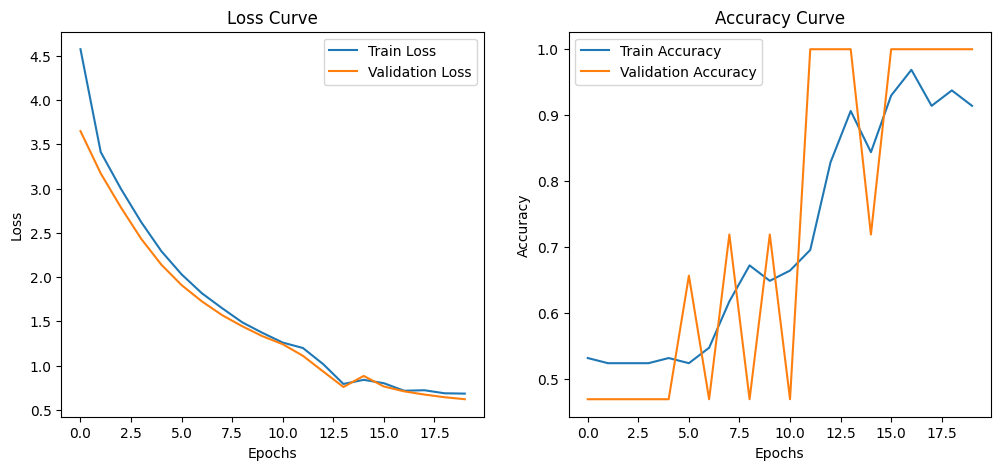

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
